In [3]:
import pandas as pd
import geopandas as gpd
import os
import re
import numpy as np
import datetime
import seaborn as sns
import matplotlib.pyplot as plt

# Create initial datasets

### Setup input/output

In [4]:
# set base directory
#baseDIR = '/mnt/d'
baseDIR = '/mnt/t/2-Projects/Thunder Basin/'
#baseDIR = 'T:/2-Projects/Thunder Basin/'

# set input directory
#inDIR = 'TBNG/data/veg/NEX'
inDIR = 'NestedExclosures/Data/Multi-Year Data/old/'

# set input files
#inXLSX = '2015-2021 Herb_8Mar2022ce_fixedVOR.xlsx'
inXLSX = '2015-2022 Herb_8Mar2023sk.xlsx'
tb_plant_list_f = '/mnt/t/2-Projects/Thunder Basin/3. Plant ID/MasterPlantList_22Jul2020.xlsx'

# set location file
inSHP = 'data/shps/20m_Transects_ALL_26jun2015.shp'
# NOTE: original file location T:\3-GIS\ThunderBasin\Exclosure_Study_Connell

# change working directory to be project directory
os.chdir(os.path.dirname(os.getcwd()))

# set output directories
outDIR_clip = 'data/clip'
outDIR_vor = 'data/vor'
outDIR_vor_train = 'data/vor_train'
outDIR_pf_train = 'data/pf_train'
if not os.path.exists(os.path.join(os.getcwd(), outDIR_clip)):
    os.mkdir(os.path.join(os.getcwd(), outDIR_clip))
if not os.path.exists(os.path.join(os.getcwd(), outDIR_vor)):
    os.mkdir(os.path.join(os.getcwd(), outDIR_vor))
if not os.path.exists(os.path.join(os.getcwd(), outDIR_vor_train)):
    os.mkdir(os.path.join(os.getcwd(), outDIR_vor_train))
if not os.path.exists(os.path.join(os.getcwd(), outDIR_pf_train)):
    os.mkdir(os.path.join(os.getcwd(), outDIR_pf_train))

### Load data

In [7]:
# create an Excel file object for investigating contents
nex_xlsx = pd.ExcelFile(os.path.join(baseDIR, inDIR, inXLSX))
#nex_xlsx = pd.ExcelFile(os.path.join('T:/2-Projects/Thunder Basin/NestedExclosures/Data/Multi-Year Data', inXLSX))

# display the sheet names in the .xlsx file
display(nex_xlsx.sheet_names)

['Metadata 15-21',
 'VOR 15-21',
 'Basal 15-21',
 'Biomass-FQ 15-21',
 'Cover 15-21',
 'Pin Frame 16-21',
 'Pin_Calibration17-21',
 'Dung 15-21',
 'Grouse Pellets 15-21',
 'Ants 15-21',
 'PDog_activity 17-21',
 'Pin_CalibClip_Shrubs 17-18',
 'Fires',
 'SmMammExcl']

In [8]:
# Create the desired dataframes by parsing the individual sheets
df_nex_bm = nex_xlsx.parse(sheet_name='Biomass-FQ 15-21', header=1, usecols='B:AL')
df_nex_pf = nex_xlsx.parse(sheet_name='Pin_Calibration17-21', header=0)

In [9]:
# load shapefile and drop null values
gdf_nex = gpd.read_file(inSHP)
gdf_nex = gdf_nex[gdf_nex['Name'].notnull()]
# create ID's
gdf_nex['Transect ID'] = gdf_nex.apply(lambda x: '-'.join(x[['Name', 'Disturbanc', 'Exclosure']]).lower(), axis=1)
# get centroid of each transect
gdf_nex['Mean.GPS_E.Biomass'] = gdf_nex.geometry.centroid.x
gdf_nex['Mean.GPS_N.Biomass'] = gdf_nex.geometry.centroid.y

# Biomass dataset

#### Clean up dates

In [10]:
# create a mask to identify all values that are 'date-like'
dates_bm_mask = df_nex_bm['Date'].map(lambda x: bool(re.match('\d\d\d\d-\d\d-\d\d 00:00:00', str(x))))
# summarize to find all unique values in the 'Date' column for each year
dates_yrly_bm = pd.DataFrame(df_nex_bm.groupby('Year')['Date'].unique()).explode('Date')
# create a mask of 'date-like' values from the unique values pulled for each year
dates_yrly_bm_mask = dates_yrly_bm['Date'].map(lambda x: bool(re.match('\d\d\d\d-\d\d-\d\d 00:00:00', str(x))))
# create a Series of the 'date-like' unique values
dates_yrly_bm_good = dates_yrly_bm['Date'][dates_yrly_bm_mask].astype(np.datetime64)
# get the average date for each month of each year for manually correcting vague dates
dates_yrly_bm_avgs = dates_yrly_bm_good.groupby(['Year', dates_yrly_bm_good.dt.month_name()]).mean().dt.date

In [11]:
# display the average dates for each month of each year
display(dates_yrly_bm_avgs)

Year  Date  
2016  August    2016-08-02
      July      2016-07-08
2017  July      2017-07-19
2018  August    2018-08-03
      July      2018-07-16
      June      2018-06-16
2019  August    2019-08-06
      July      2019-07-16
      June      2019-06-25
2020  August    2020-08-06
      July      2020-07-07
2021  August    2021-08-04
      July      2021-07-13
      June      2021-06-30
2022  July      2022-07-08
      June      2022-06-29
Name: Date, dtype: object

In [12]:
# display the unique non-'date-like' values present in each year
display(dates_yrly_bm['Date'][~dates_yrly_bm_mask])

Year
2015                     na
2015           7/20-23/2015
2015          7/27-8/5/2015
2016           6/6-6/9/2016
2016          na, July 2016
2017          na, June 2017
2017          na, July 2017
2017        na, August 2017
2020    7/6/2020 - 7/7/2020
2020    7/8/2020 - 7/9/2020
2020      8/4/2020-8/5/2020
2022                    NaN
Name: Date, dtype: object

In [13]:
# create a dictionary to manually change non-'date-like' values to dates
dates_bm_dict = {
    2015: {
        'na': pd.to_datetime('2015-07-27').date(),
        '7/20-23/2015': pd.to_datetime('2015-07-21').date(),
        '7/27-8/5/2015': pd.to_datetime('2015-08-01').date()
    },
    2016: {
        'na, July 2016': dates_yrly_bm_avgs.loc[(2016, 'July')],
        '6/6-6/9/2016': pd.to_datetime('2016-06-08').date(),
    },
    2017: {
        'na, June 2017': pd.to_datetime('2017-06-22').date(),
        'na, July 2017': dates_yrly_bm_avgs.loc[(2017, 'July')],
        'na, August 2017': pd.to_datetime('2017-08-04').date(),
    },
    2020: {
        '7/6/2020 - 7/7/2020': pd.to_datetime('2020-07-07').date(),
        '7/8/2020 - 7/9/2020': pd.to_datetime('2020-07-09').date(),
        '8/4/2020-8/5/2020': pd.to_datetime('2020-08-05').date()
    },
    2022: {np.nan: np.nan}
}

In [14]:
# Create a new column of cleaned up dates from 'date-like' values and manual replacement
df_nex_bm.loc[dates_bm_mask, 
              'Date_cln'] = df_nex_bm['Date'][dates_bm_mask].astype(np.datetime64).dt.date
df_nex_bm.loc[~dates_bm_mask, 
              'Date_cln'] = df_nex_bm[~dates_bm_mask].apply(lambda x: dates_bm_dict[x.Year][x.Date], axis=1)
df_nex_bm['Date_cln'] = df_nex_bm['Date_cln'].astype(np.datetime64)

In [15]:
# display data types
display(df_nex_bm.dtypes)

Observers                           object
Year                                 int64
Date                                object
Transect ID                         object
Site                                object
Disturbance                         object
Exclosure                           object
Rep                                float64
Biomass?                            object
Forage?                             object
Pin Frame?                          object
Area (m^2)                         float64
% ARTR                              object
% sd ARTR                          float64
% KRLA                              object
% ARCA                             float64
% ATCA                             float64
# OPPO cladodes                    float64
# COVI                             float64
% OPPO                             float64
Total Weight (g)                   float64
Total Weight (g/m^2)               float64
How weighed?                        object
C4 weight (

In [16]:
# remove all rows with weight value entered as 'x'
df_nex_bm = df_nex_bm[~(
    df_nex_bm.loc[:, df_nex_bm.columns.str.contains('eight \(g\)')] == 'x').any(axis=1)]

# convert weight values to float
df_nex_bm.loc[:, df_nex_bm.columns.str.contains('eight \(g\)')] = df_nex_bm.loc[:, df_nex_bm.columns.str.contains('eight \(g\)')].astype('float')

# remove all rows with NA values for Total weight, including those signified with negative values
df_nex_bm = df_nex_bm[df_nex_bm['Total Weight (g)'].notnull()]
df_nex_bm = df_nex_bm[df_nex_bm['Total Weight (g)'] >= 0]

# remove all clipping done for PASM only
df_nex_bm = df_nex_bm[df_nex_bm['PASM or COMP?'] != 'PASM']

# calculate area biomass density from quadrat size
#df_nex_bm['Total Weight (g/m^2)'] = df_nex_bm['Total Weight (g)'] / df_nex_bm['Area (m^2)']

# manually remove several rows with missing data not yet classified with -1
#df_nex_bm = df_nex_bm[~((df_nex_bm['Date_cln'] == pd.to_datetime('2020-08-05')) &
#                        (df_nex_bm['Transect ID'] == 'west fork-control-ungulate ex'))]

#df_nex_bm = df_nex_bm[~((df_nex_bm['Date_cln'] == pd.to_datetime('2020-08-06')) &
#                        (df_nex_bm['Transect ID'] == 'wildcat-control-livestock ex'))]

#df_nex_bm = df_nex_bm[~((df_nex_bm['Date_cln'] == pd.to_datetime('2020-08-06')) &
#                        (df_nex_bm['Transect ID'] == 'wildcat-control-out'))]

### Visualize data to check that it makes sense

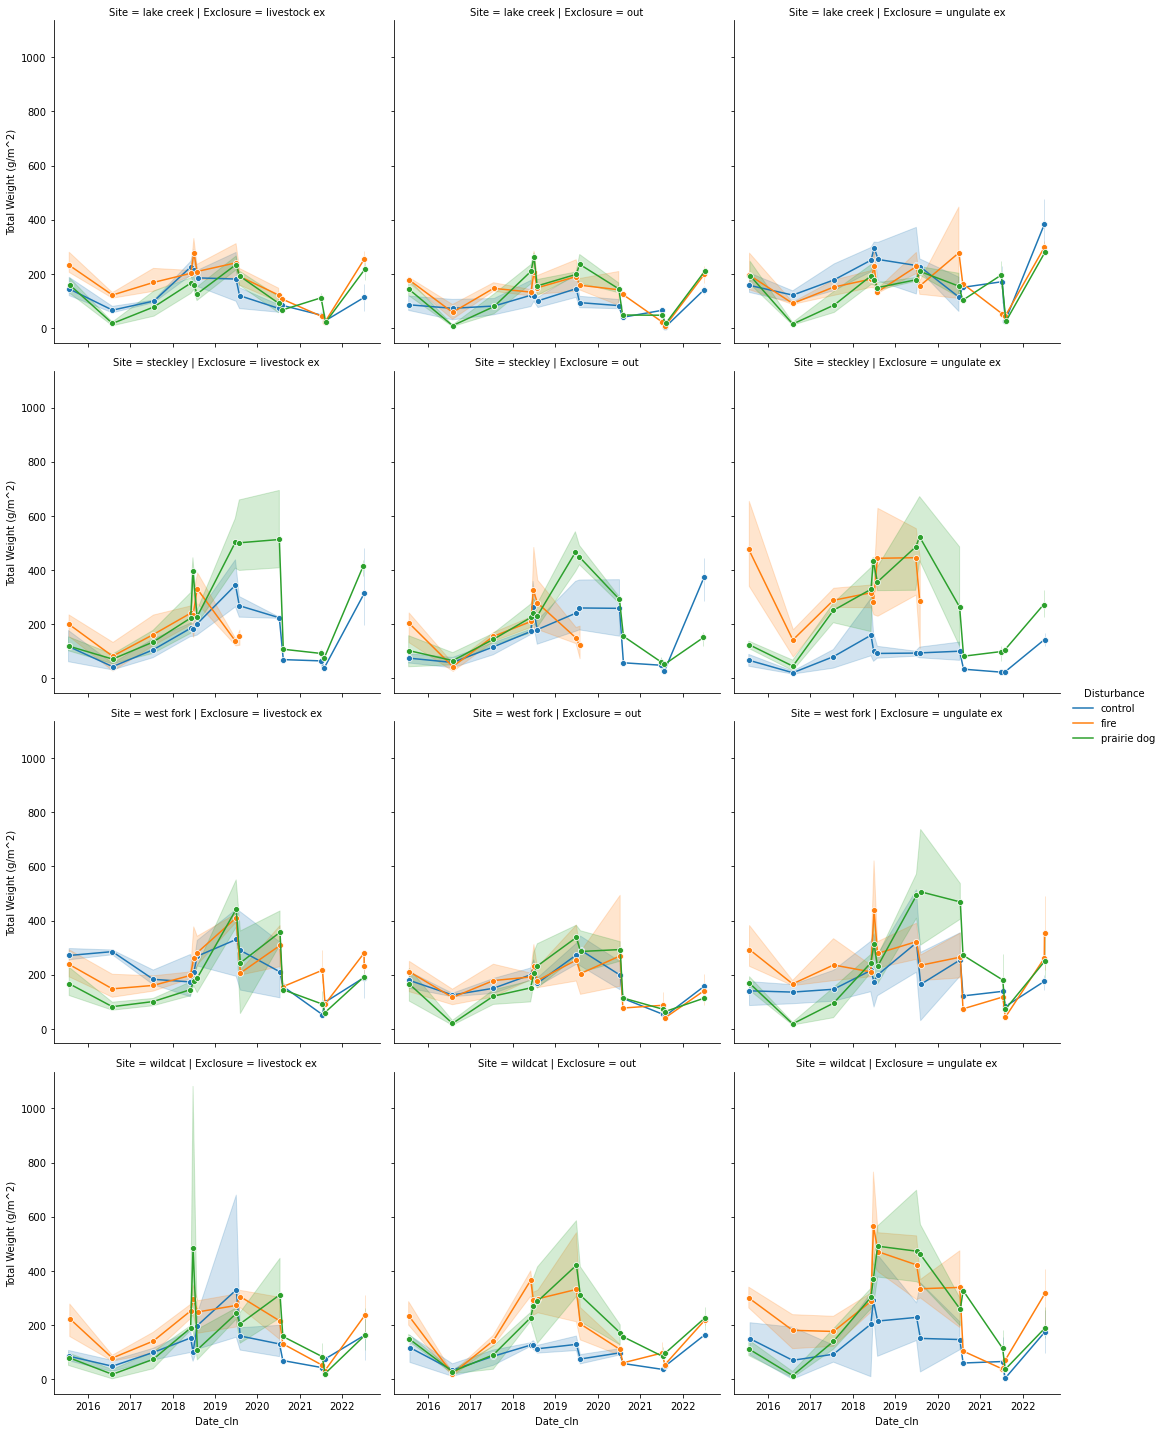

In [17]:
# plot biomass data
sns.relplot(x='Date_cln', y='Total Weight (g/m^2)', hue='Disturbance', col='Exclosure', row='Site',
            data=df_nex_bm, kind='line', marker="o")

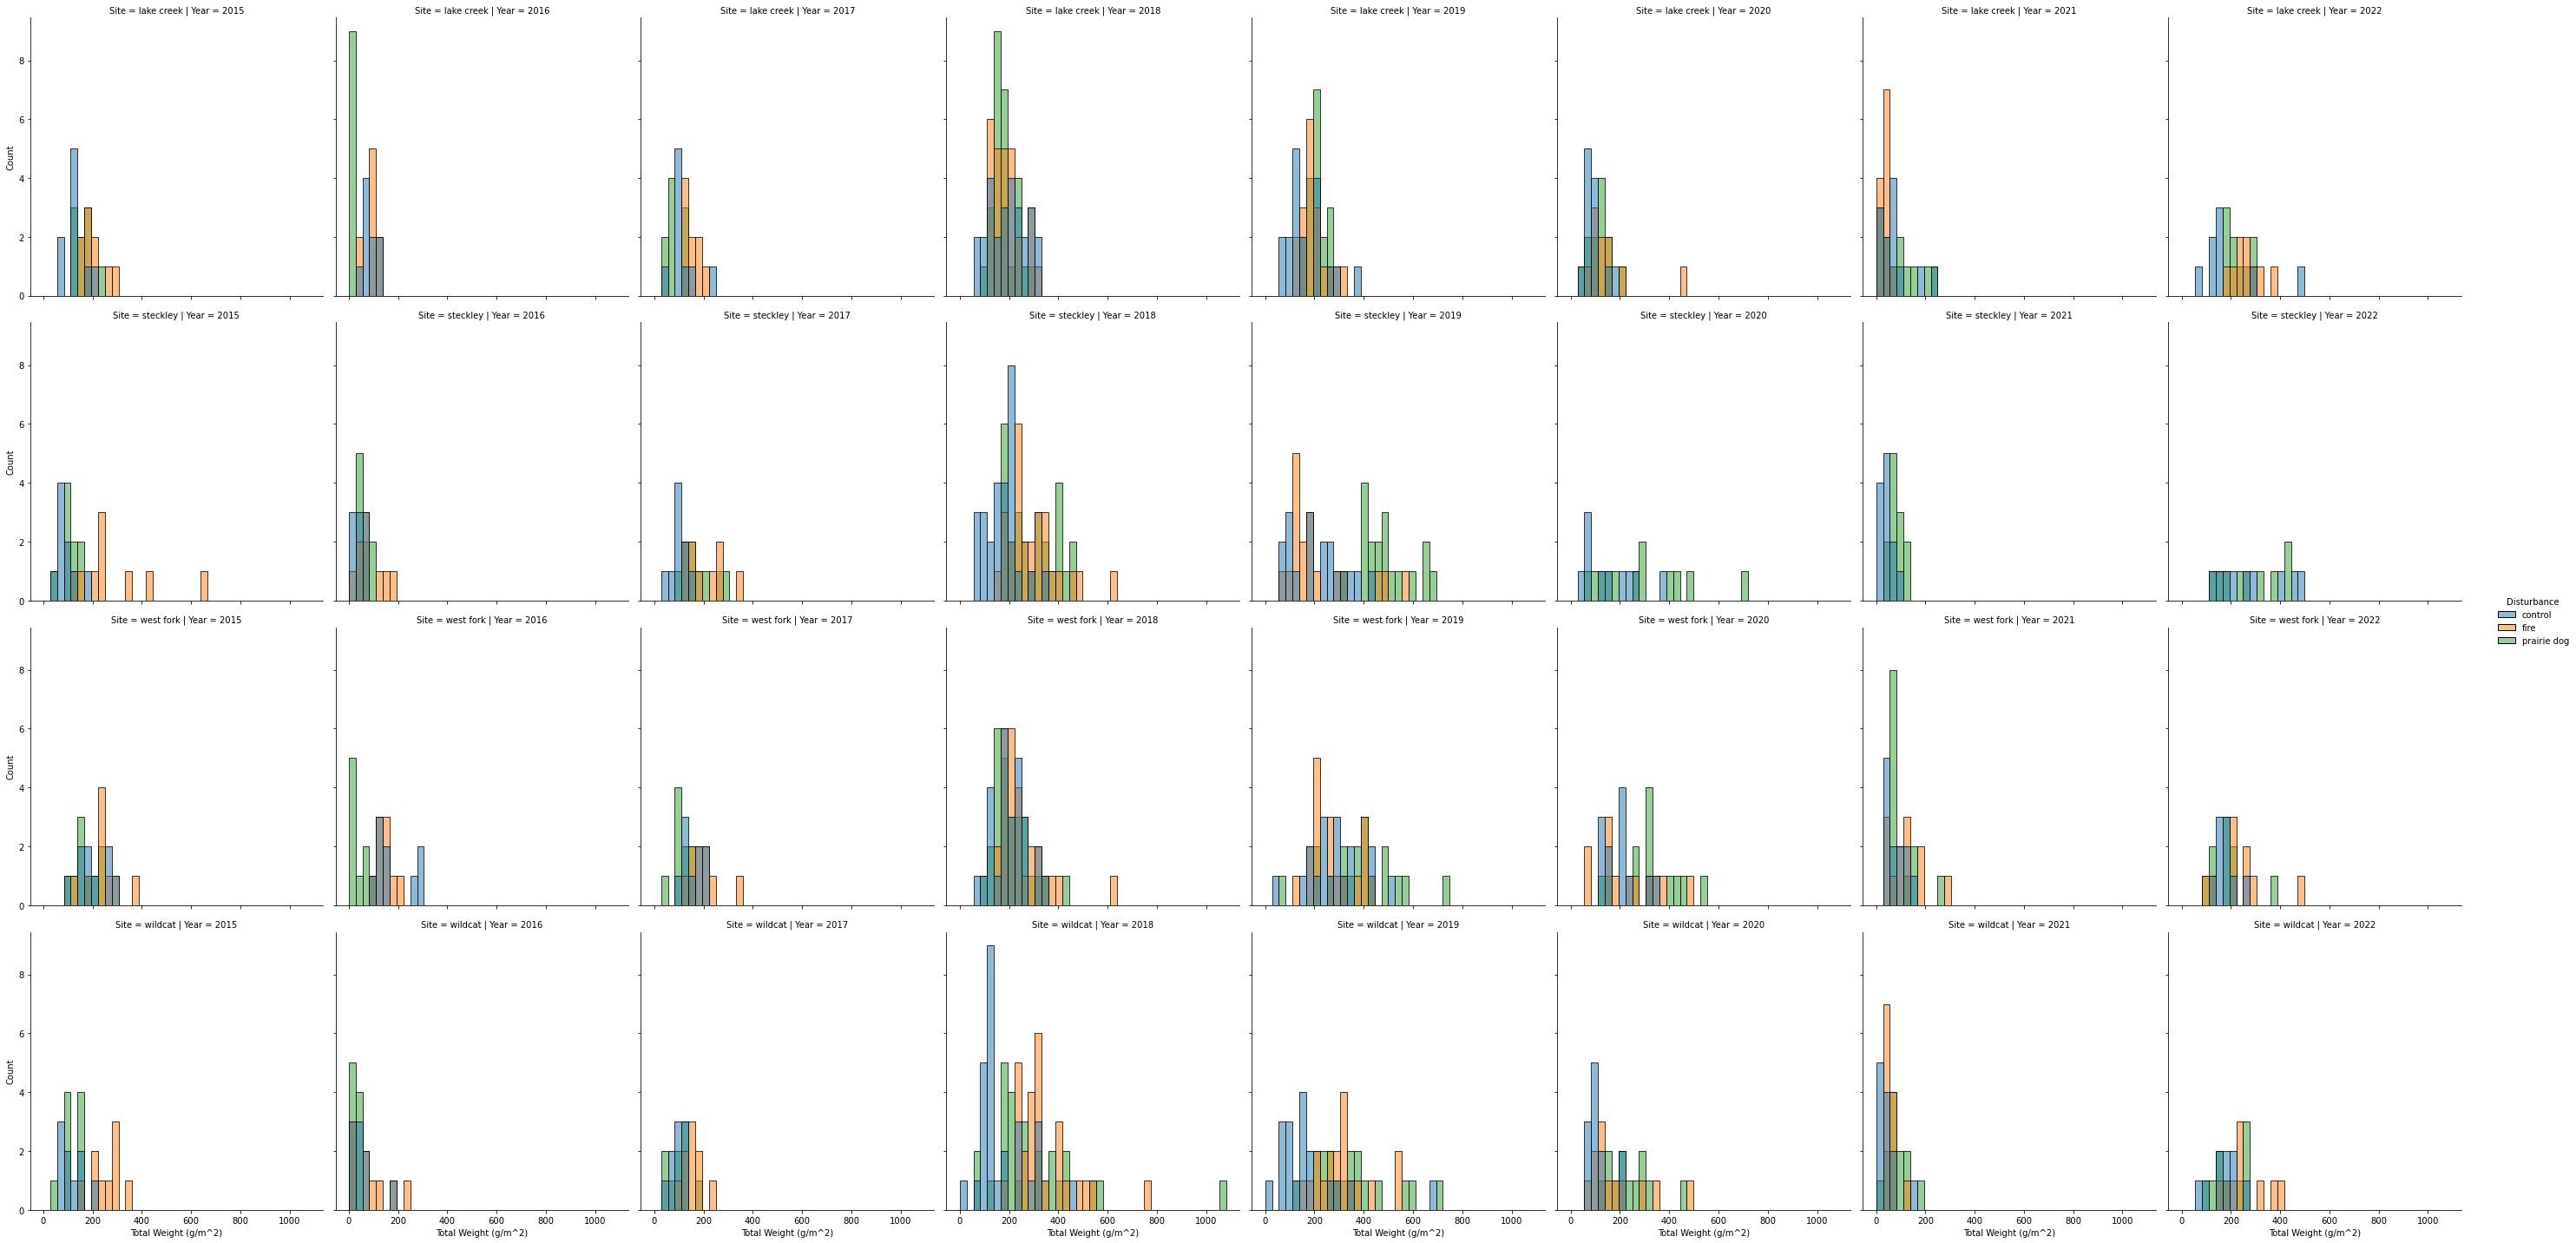

In [18]:
sns.displot(x='Total Weight (g/m^2)', hue='Disturbance', col='Year', row='Site',
            data=df_nex_bm, kind='hist')

In [19]:
df_nex_bm.columns

Index(['Observers', 'Year', 'Date', 'Transect ID', 'Site', 'Disturbance',
       'Exclosure', 'Rep', 'Biomass?', 'Forage?', 'Pin Frame?', 'Area (m^2)',
       '% ARTR', '% sd ARTR', '% KRLA', '% ARCA', '% ATCA', '# OPPO cladodes',
       '# COVI', '% OPPO', 'Total Weight (g)', 'Total Weight (g/m^2)',
       'How weighed?', 'C4 weight (g)', 'C3 weight (g)', 'Bromes weight (g)',
       'Forbs weight (g)', 'Ann Forb weight (g)', 'Per Forb weight (g)',
       'VUOC weight (g)', 'Subshrub weight (g)', 'Standing Dead weight (g)',
       'BOGR/BUDA', 'Other', 'Check', 'Ward Lab ID', 'PASM or COMP?',
       'Date_cln'],
      dtype='object')

In [20]:
# get VOR counts by observer
bm_domin_obs = df_nex_bm.groupby(
    ['Site', 
         'Disturbance',
         'Exclosure',
         'Transect ID',
         'Date_cln'])['Observers'].value_counts().to_frame('obs_count')
# get dominant observer by index
bm_domin_obs = bm_domin_obs.loc[bm_domin_obs.groupby(
    level=['Site', 
         'Disturbance',
         'Exclosure',
         'Transect ID',
         'Date_cln'])['obs_count'].idxmax()].reset_index(level=-1)

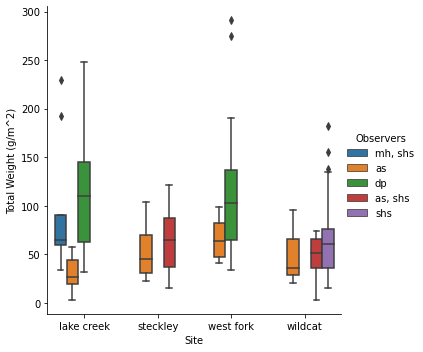

In [21]:
sns.catplot(data=df_nex_bm[df_nex_bm['Year'] == 2021],
            x='Site', y='Total Weight (g/m^2)', 
            hue='Observers', kind='box')

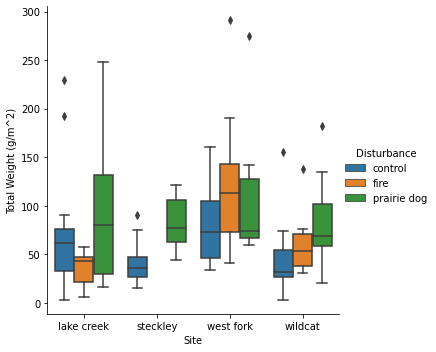

In [22]:
sns.catplot(data=df_nex_bm[df_nex_bm['Year'] == 2021],
            x='Site', y='Total Weight (g/m^2)', 
            hue='Disturbance', kind='box')

In [23]:
df_nex_bm[df_nex_bm['Year'] == 2021].groupby(['Site', 'Disturbance'])['Observers'].value_counts()

Site        Disturbance  Observers
lake creek  control      mh, shs       9
                         as            3
            fire         as           12
            prairie dog  dp            9
                         as            3
steckley    control      as, shs       9
                         as            3
            prairie dog  as, shs       9
                         as            3
west fork   control      dp            9
                         as            3
            fire         dp            9
                         as            3
            prairie dog  dp            9
                         as            3
wildcat     control      shs           9
                         as, shs       3
            fire         shs           9
                         as, shs       3
            prairie dog  shs           9
                         as            3
Name: Observers, dtype: int64

### Remove 'AS' observer from 2021 biomass data

In [24]:
df_nex_bm = df_nex_bm[~((df_nex_bm['Year'] == 2021) & (df_nex_bm['Observers'] == 'as'))].copy()

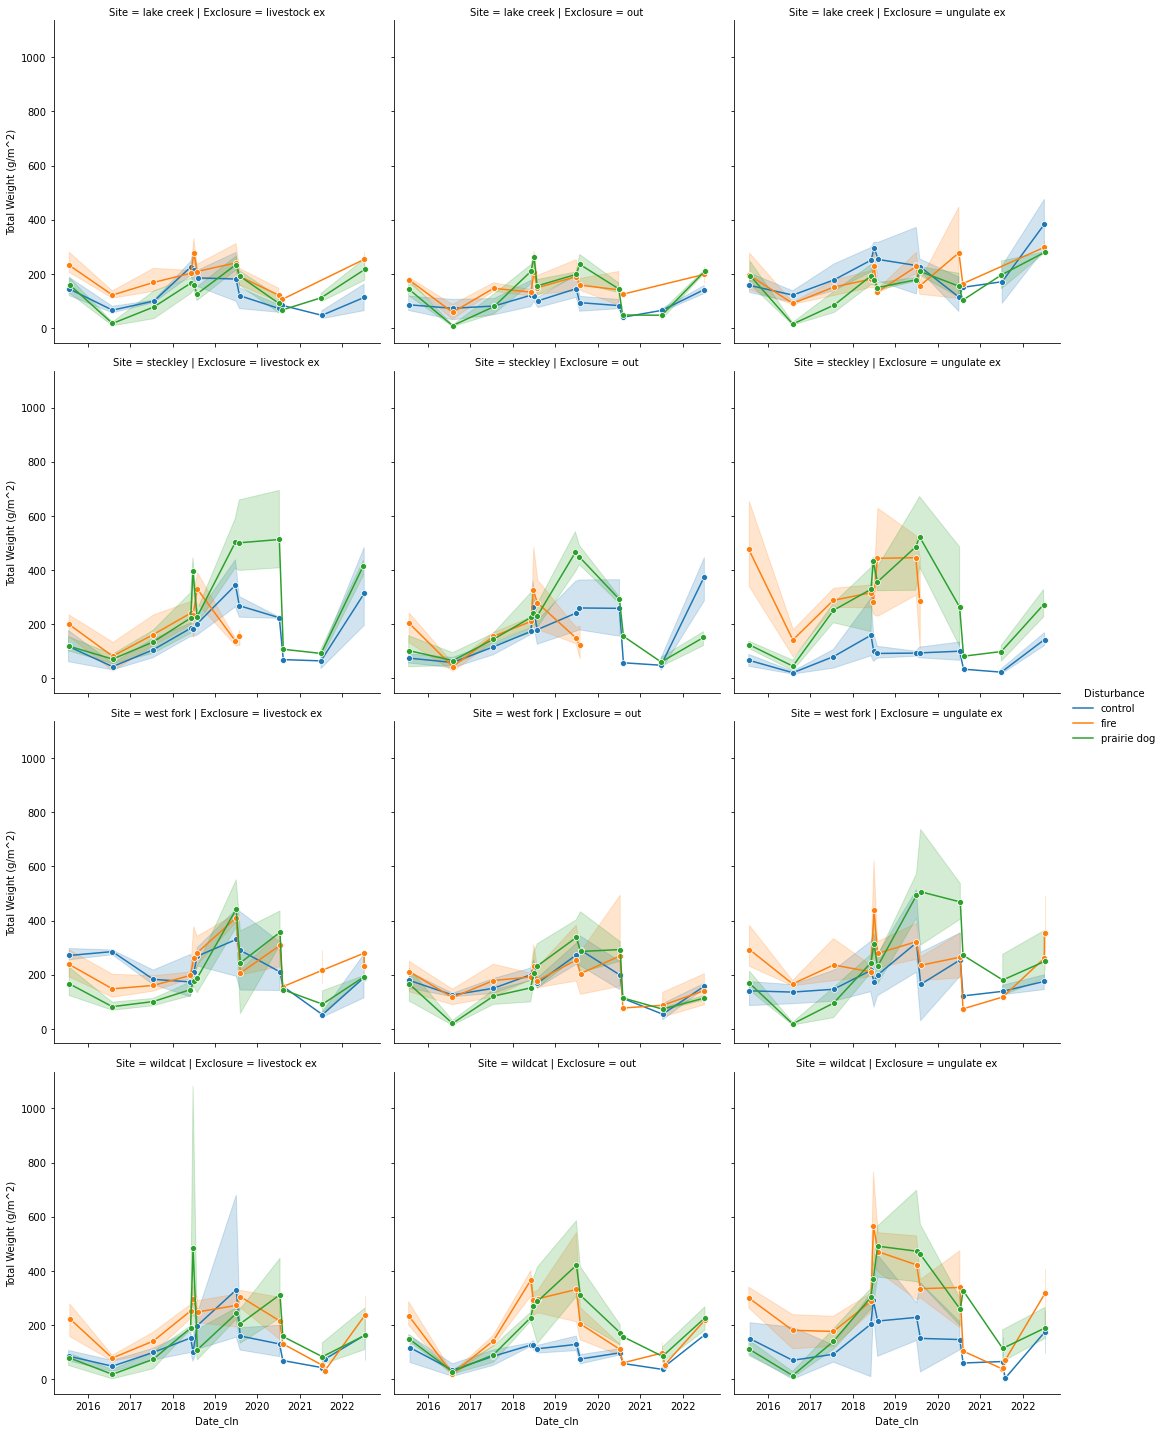

In [25]:
# plot biomass data
sns.relplot(x='Date_cln', y='Total Weight (g/m^2)', hue='Disturbance', col='Exclosure', row='Site',
            data=df_nex_bm, kind='line', marker="o")

In [26]:
df_nex_bm[df_nex_bm['Year'] == 2021]['Observers'].unique()

array(['mh, shs', 'dp', 'as, shs', 'shs'], dtype=object)

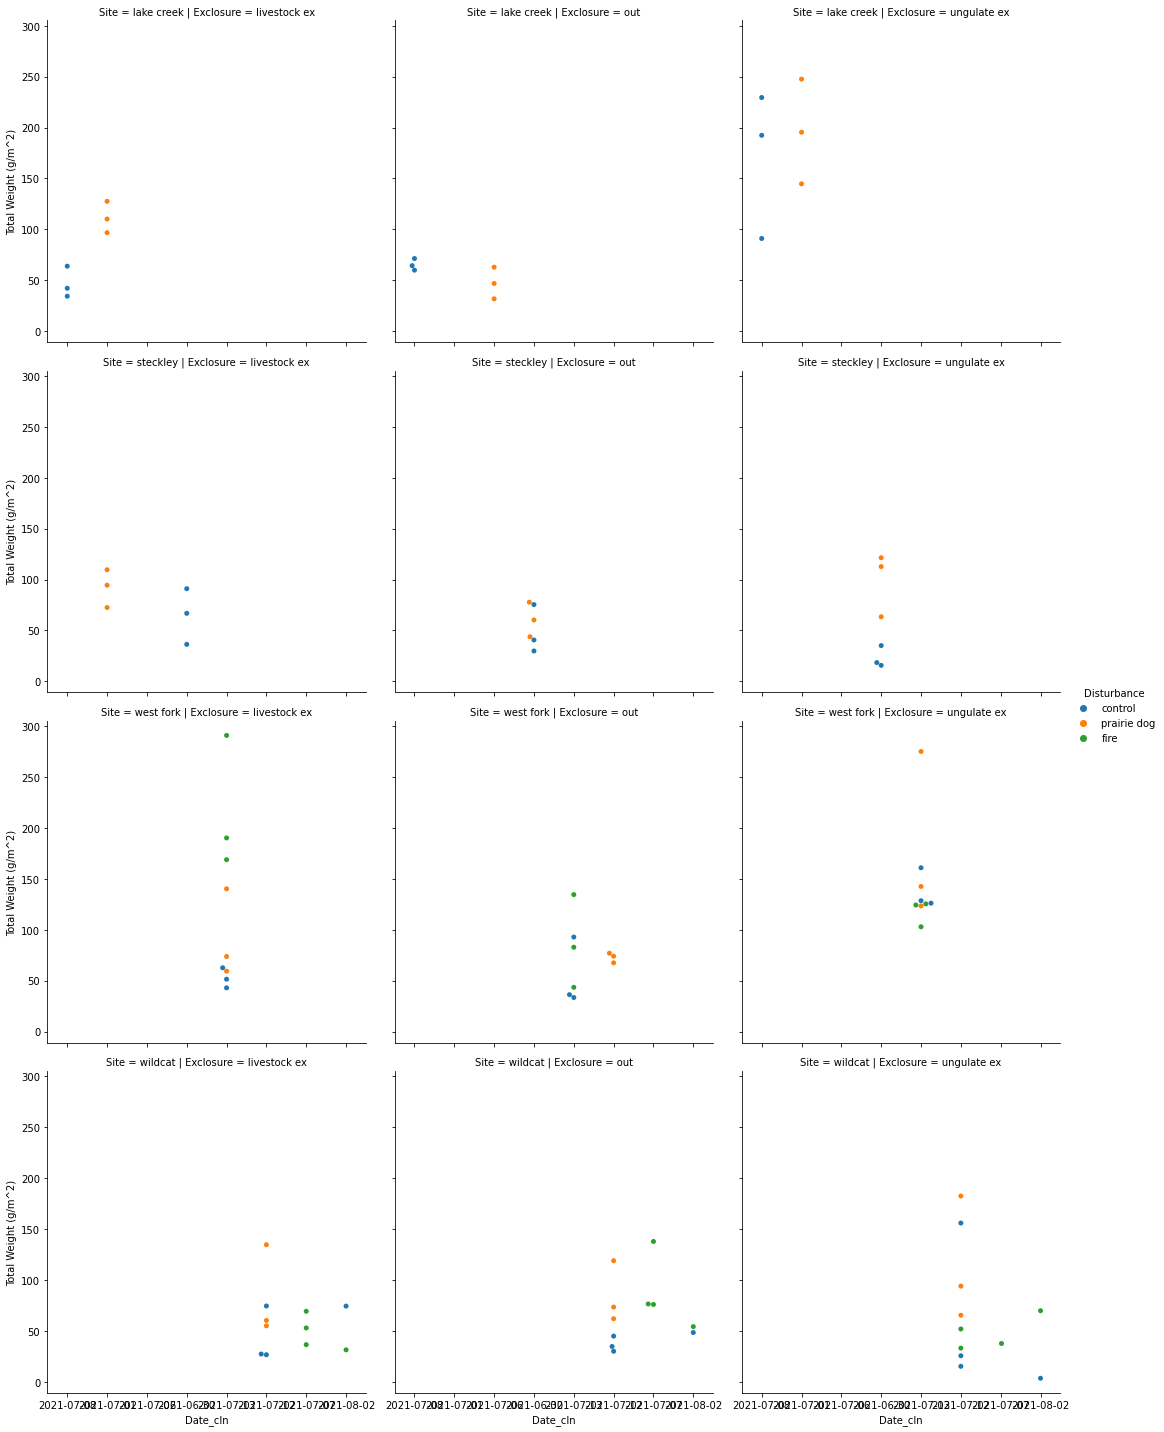

In [30]:
# plot biomass data
sns.catplot(x='Date_cln', y='Total Weight (g/m^2)', hue='Disturbance', col='Exclosure', row='Site',
            data=df_nex_bm[df_nex_bm['Year'] == 2021], kind='swarm', marker="o")

### Save biomass data to disk

In [31]:
# aggregate data to experimental unit
remove_indv_na = True
if remove_indv_na:
    df_nex_bm_out = df_nex_bm[~(
        df_nex_bm.loc[:, df_nex_bm.columns.str.contains('weight \(g\)')] < 0).any(axis=1)].groupby(
        ['Site', 
         'Disturbance',
         'Exclosure',
         'Transect ID',
         'Date_cln']).mean().sort_values('Date_cln')
else:
    df_nex_bm_out = df_nex_bm.groupby(['Site',
                                       'Disturbance',
                                       'Exclosure',
                                       'Transect ID',
                                       'Date_cln']).mean().sort_values('Date_cln')

In [32]:
# get the dominant observer
df_nex_bm_out['domin_obs'] = bm_domin_obs['Observers']

In [33]:
# reset the index
df_nex_bm_out = df_nex_bm_out.reset_index()

In [34]:
# check that all ID's are in shapefile
df_nex_bm_out['Transect ID'][~df_nex_bm_out['Transect ID'].isin(gdf_nex['Transect ID'].unique())].unique()

array([], dtype=object)

In [35]:
# check that all ID's are in dataset
gdf_nex['Transect ID'][~gdf_nex['Transect ID'].isin(df_nex_bm_out['Transect ID'].unique())].unique()

array([], dtype=object)

In [36]:
# get GPS locs from transect shapefile (centroids)
df_nex_bm_out = pd.merge(df_nex_bm_out,
                         gdf_nex[['Transect ID', 'Mean.GPS_E.Biomass', 'Mean.GPS_N.Biomass']],
                         on= 'Transect ID',
                         suffixes=['_clip', '_shp'],
                         how='left')

In [37]:
# save data to disk
df_nex_bm_out.to_csv(os.path.join(os.getcwd(), outDIR_clip, 'TB_nex_clip.csv'), index=False)

### Prep biomass values for joining to pin frame

In [38]:
# create separate biomass dataframe that has functional group data for pinframe calibration
df_nex_bm_fg = df_nex_bm[df_nex_bm['Pin Frame?'] == 'x'].copy(deep=True)

In [39]:
# fill all functional group clipping NA values with zeros for averaging
df_nex_bm_fg.loc[
    :, df_nex_bm_fg.columns.str.contains('weight \(g\)')] = df_nex_bm_fg.loc[
    :, df_nex_bm_fg.columns.str.contains('weight \(g\)')].fillna(0)
df_nex_bm_fg.loc[:, 'BOGR/BUDA'] = df_nex_bm_fg.loc[:, 'BOGR/BUDA'].fillna(0)

# remove all rows with negative values or convert to NAN
remove_indv_na = False
if remove_indv_na:
    df_nex_bm_fg = df_nex_bm_fg[~(
        df_nex_bm_fg.loc[:, df_nex_bm_fg.columns.str.contains('weight \(g\)')] < 0).any(axis=1)]
    df_nex_bm_fg = df_nex_bm_fg[~(df_nex_bm_fg.loc[:, 'BOGR/BUDA'] < 0)]
else:
    for c in list(df_nex_bm_fg.columns[df_nex_bm_fg.columns.str.contains('weight \(g\)')]) + ['BOGR/BUDA']:
        df_nex_bm_fg[c] = df_nex_bm_fg[c].apply(lambda x: np.nan if x < 0 else x)

In [40]:
df_nex_bm_fg.loc[
    :, df_nex_bm_fg.columns.str.contains('weight \(g\)')].columns

Index(['C4 weight (g)', 'C3 weight (g)', 'Bromes weight (g)',
       'Forbs weight (g)', 'Ann Forb weight (g)', 'Per Forb weight (g)',
       'VUOC weight (g)', 'Subshrub weight (g)', 'Standing Dead weight (g)'],
      dtype='object')

In [41]:
# create additional functional group groupings
df_nex_bm_fg['Ann Grass weight (g)'] = df_nex_bm_fg['Bromes weight (g)'] + df_nex_bm_fg['VUOC weight (g)']

In [42]:
# create consistent Forbs weight across all years
forb_years = df_nex_bm_fg.loc[(df_nex_bm_fg['Forbs weight (g)'].isnull() | df_nex_bm_fg['Forbs weight (g)'] == 0) & 
              (df_nex_bm_fg[['Ann Forb weight (g)', 'Per Forb weight (g)']].notnull().all(axis=1) & 
               df_nex_bm_fg[['Ann Forb weight (g)', 'Per Forb weight (g)']].sum(axis=1) != 0),
                           'Year'].unique()
df_nex_bm_fg['Forbs weight (g)'] = df_nex_bm_fg.apply(
    lambda x: np.nansum([x['Ann Forb weight (g)'], x['Per Forb weight (g)']]) if x['Year'] in forb_years else x['Forbs weight (g)'],
    axis=1)

# create consistent C4 weight across all years
c4_years = df_nex_bm_fg.loc[(df_nex_bm_fg['BOGR/BUDA'].notnull() | df_nex_bm_fg['BOGR/BUDA'] != 0) &
                            (df_nex_bm_fg['C4 weight (g)'].isnull() | df_nex_bm_fg['C4 weight (g)'] == 0), 'Year'].unique()

df_nex_bm_fg['C4 weight (g)'] = df_nex_bm_fg.apply(
    lambda x: x['C4 weight (g)'] + x['BOGR/BUDA'] if x['Year'] in c4_years else x['C4 weight (g)'],
    axis=1)

In [43]:
c4_years

array([2017, 2018, 2019, 2020, 2021])

In [44]:
# create columns for aerial density of functional group biomass
for c in [c for c in df_nex_bm_fg.columns if ' (g)' in c]:
    df_nex_bm_fg[re.sub(' \(g\)', ' (g/m^2)', c)] = df_nex_bm_fg[c] * 2.0

In [45]:
df_nex_bm_fg.loc[((df_nex_bm_fg['Forbs weight (g)'].isnull()) | (df_nex_bm_fg['Forbs weight (g)'] == 0)) & 
              (df_nex_bm_fg[['Ann Forb weight (g)', 'Per Forb weight (g)']].sum(axis=1) != 0)]

,Observers,Year,Date,Transect ID,Site,Disturbance,Exclosure,Rep,Biomass?,Forage?,...,C4 weight (g/m^2),C3 weight (g/m^2),Bromes weight (g/m^2),Forbs weight (g/m^2),Ann Forb weight (g/m^2),Per Forb weight (g/m^2),VUOC weight (g/m^2),Subshrub weight (g/m^2),Standing Dead weight (g/m^2),Ann Grass weight (g/m^2)


In [46]:
df_nex_bm_fg.loc[((df_nex_bm_fg['C4 weight (g)'].isnull()) | (df_nex_bm_fg['C4 weight (g)'] == 0)) & 
              (df_nex_bm_fg['BOGR/BUDA'].notnull() & df_nex_bm_fg['BOGR/BUDA'] != 0)]

,Observers,Year,Date,Transect ID,Site,Disturbance,Exclosure,Rep,Biomass?,Forage?,...,C4 weight (g/m^2),C3 weight (g/m^2),Bromes weight (g/m^2),Forbs weight (g/m^2),Ann Forb weight (g/m^2),Per Forb weight (g/m^2),VUOC weight (g/m^2),Subshrub weight (g/m^2),Standing Dead weight (g/m^2),Ann Grass weight (g/m^2)


In [47]:
df_nex_bm_fg.loc[df_nex_bm_fg['C4 weight (g)'].isnull()]

,Observers,Year,Date,Transect ID,Site,Disturbance,Exclosure,Rep,Biomass?,Forage?,...,C4 weight (g/m^2),C3 weight (g/m^2),Bromes weight (g/m^2),Forbs weight (g/m^2),Ann Forb weight (g/m^2),Per Forb weight (g/m^2),VUOC weight (g/m^2),Subshrub weight (g/m^2),Standing Dead weight (g/m^2),Ann Grass weight (g/m^2)


### Visualize data to check that it makes sense

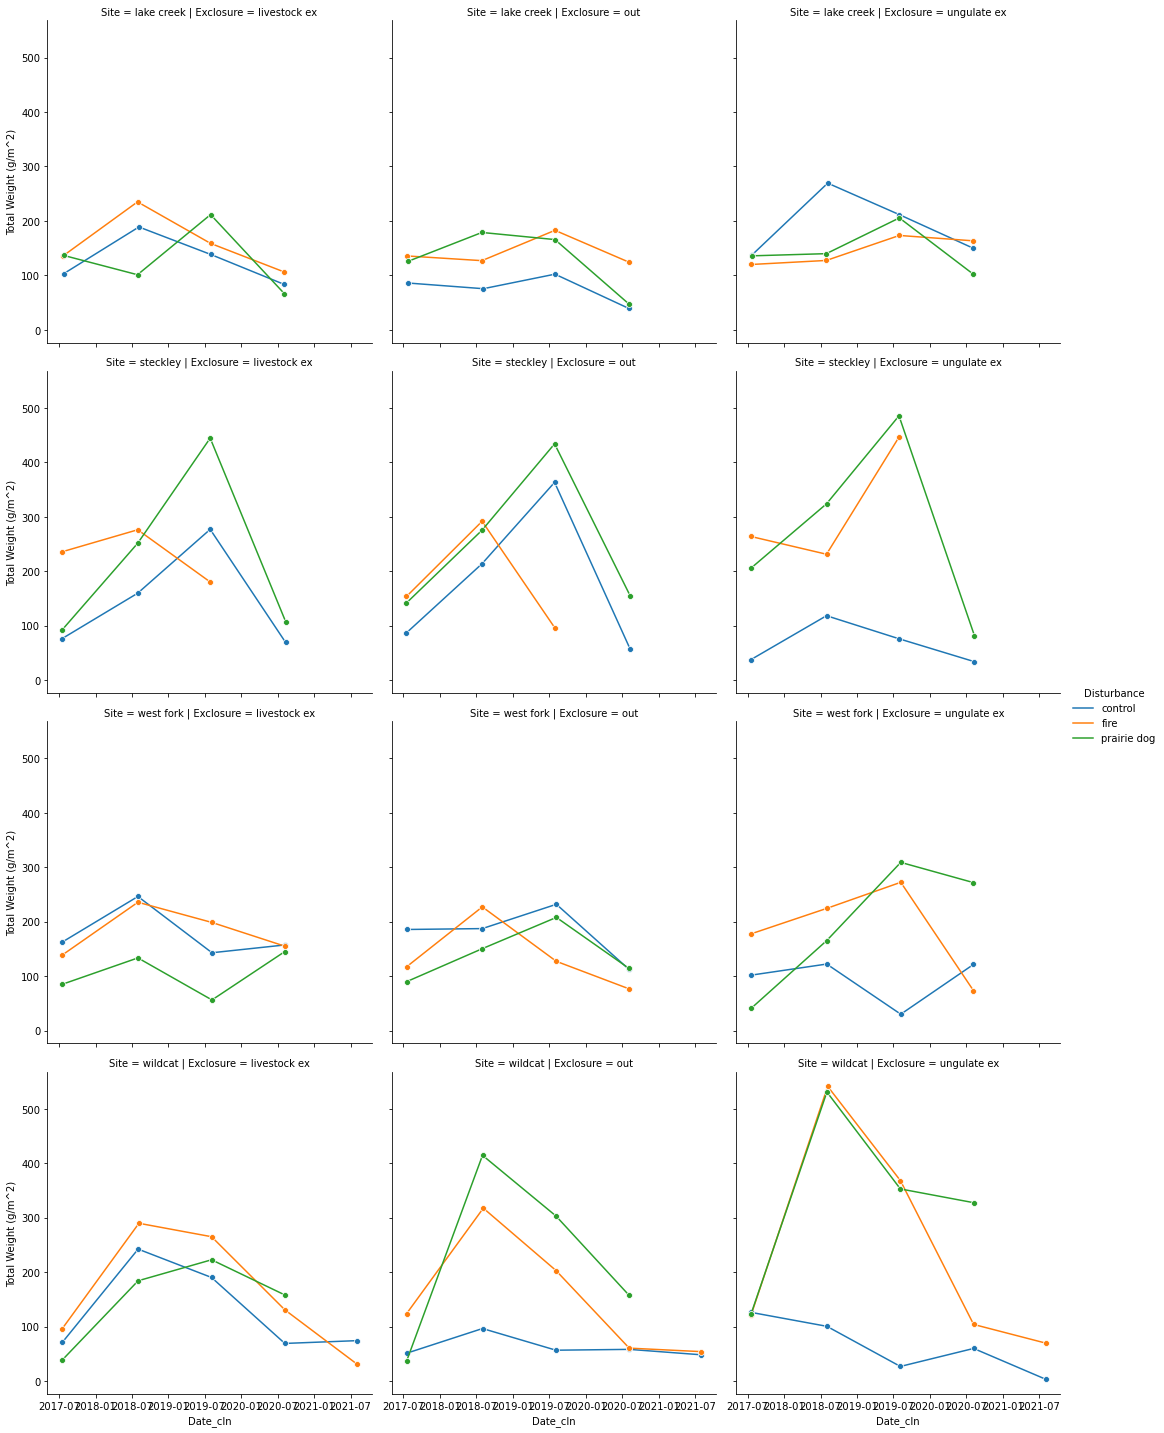

In [48]:
# plot pin-frame calibration data
sns.relplot(x='Date_cln', y='Total Weight (g/m^2)', hue='Disturbance', col='Exclosure', row='Site',
            data=df_nex_bm_fg, kind='line', marker="o")

# Pin Frame Dataset

### Combine Biomass and Pin Frame datasets

In [49]:
# Create a new column in the Pin Frame dataframe pulling the nearest Biomass sampling date
df_nex_pf = pd.merge_asof(df_nex_pf.sort_values('Date'), 
                          df_nex_bm_fg.groupby(['Site',
                                             'Disturbance',
                                             'Exclosure',
                                             'Date_cln']).mean().reset_index().sort_values('Date_cln')[['Site',
                                                                                                        'Disturbance',
                                                                                                        'Exclosure',
                                                                                                        'Total Weight (g/m^2)',
                                                                                                        'C4 weight (g/m^2)',
                                                                                                        'C3 weight (g/m^2)', 
                                                                                                        'Forbs weight (g/m^2)', 
                                                                                                        'Bromes weight (g/m^2)',
                                                                                                        'VUOC weight (g/m^2)',
                                                                                                        'Ann Grass weight (g/m^2)', 
                                                                                                        'Subshrub weight (g/m^2)',
                                                                                                        'Standing Dead weight (g/m^2)',
                                                                                                        'Date_cln']],
                          left_on='Date',
                          right_on='Date_cln',
                          by=['Site', 'Disturbance', 'Exclosure'],
                          direction='nearest',
                          tolerance=datetime.timedelta(days=15),
                          suffixes=['_x', ''])

In [50]:
# drop any records missing Biomass data
df_nex_pf = df_nex_pf[df_nex_pf['Total Weight (g/m^2)'].notnull()]

In [51]:
# Check that all values in the newly created column are present in the Biomass dates (result should be empty)
df_nex_pf['Date_cln'].sort_values().astype('str')[~df_nex_pf['Date_cln'].sort_values().isin(
    df_nex_bm_fg[df_nex_bm_fg['Year'] >= 2017]['Date_cln'])].unique()

array([], dtype=object)

### Clean up Pin Frame dataset

In [52]:
# drop basal hits
df_nex_pf = df_nex_pf[df_nex_pf['Position'] != 'basal']

# drop shrub and cactus hits since no clip data available
df_nex_pf = df_nex_pf.drop(columns='Shrub/OPPO')

In [53]:
# calculate forb hits
df_nex_pf['Forb'] = df_nex_pf['AnnualForb'] + df_nex_pf['PerennialForb']

# calculate annual grass hits
df_nex_pf['Annual Grass'] = df_nex_pf['Brome'] + df_nex_pf['VUOC']

### Calculate appropriate values at the experimental unit level

In [54]:
# aggregate data by experimental unit
df_nex_pf_agg = df_nex_pf.groupby(
    ['Site', 'Disturbance', 'Exclosure', 'Date_cln']).aggregate(
    {'Total Hits': np.sum,
     'C4P Grass': np.sum,
     'C3P Grass': np.sum,
     'Annual Grass': np.sum,
     'Forb': np.sum,
     'Brome': np.sum,
     'VUOC': np.sum,
     'Subshrub': np.sum,
     'StandingDead': np.sum,
     'TotalHerbHits': np.sum,
     'Total Weight (g/m^2)': np.mean,
     'C4 weight (g/m^2)': np.mean,
     'C3 weight (g/m^2)': np.mean,
     'Forbs weight (g/m^2)': np.mean,
     'Bromes weight (g/m^2)': np.mean,
     'VUOC weight (g/m^2)': np.mean,
     'Ann Grass weight (g/m^2)': np.mean,
     'Subshrub weight (g/m^2)': np.mean,
     'Standing Dead weight (g/m^2)': np.mean}).reset_index()

In [55]:
pf_colname_mapper = {
    'C4P Grass': 'hits_C4',
    'C3P Grass': 'hits_C3',
    'Annual Grass': 'hits_AnnGrass',
    'Forb': 'hits_Forb',
    'Brome': 'hits_Brome',
    'VUOC': 'hits_VUOC',
    'Subshrub': 'hits_Subshrub',
    'StandingDead': 'hits_SD',
    'TotalHerbHits': 'hits_Total',
    'C4 weight (g/m^2)': 'weight_C4',
    'C3 weight (g/m^2)': 'weight_C3',
    'Ann Grass weight (g/m^2)': 'weight_AnnGrass',
    'Forbs weight (g/m^2)': 'weight_Forb',
    'Bromes weight (g/m^2)': 'weight_Brome',
    'VUOC weight (g/m^2)': 'weight_VUOC',
    'Subshrub weight (g/m^2)': 'weight_Subshrub',
    'Standing Dead weight (g/m^2)': 'weight_SD',
    'Total Weight (g/m^2)': 'weight_Total'
}

df_nex_pf_agg = df_nex_pf_agg.rename(columns=pf_colname_mapper)

In [56]:
# reset the year column
df_nex_pf_agg['Year'] = df_nex_pf_agg['Date_cln'].dt.year

# rename date column
df_nex_pf_agg = df_nex_pf_agg.rename(columns={'Date_cln': 'Date'})

### Create long-form version of data

In [57]:
# convert to long format to be able to plot with hue as the FG
df_nex_pf_agg_long = pd.wide_to_long(df_nex_pf_agg.reset_index(), 
                                     stubnames=['hits', 'weight'], 
                                     i=['Site', 'Disturbance', 'Exclosure', 'Date'], 
                                     j='FG', 
                                     sep="_", 
                                     suffix=r'\w+').reset_index()

### Check data and save to disk

In [58]:
df_nex_bm_fg.groupby('Year').count()

,Observers,Date,Transect ID,Site,Disturbance,Exclosure,Rep,Biomass?,Forage?,Pin Frame?,...,C4 weight (g/m^2),C3 weight (g/m^2),Bromes weight (g/m^2),Forbs weight (g/m^2),Ann Forb weight (g/m^2),Per Forb weight (g/m^2),VUOC weight (g/m^2),Subshrub weight (g/m^2),Standing Dead weight (g/m^2),Ann Grass weight (g/m^2)
Year,,,,,,,,,,,,,,,,,,,,,
2017,36,36,36,36,36,36,36,36,0,36,...,36,36,36,36,36,36,36,36,36,36
2018,36,36,36,36,36,36,36,36,36,36,...,36,36,36,36,36,36,36,36,36,36
2019,36,36,36,36,36,36,36,36,36,36,...,36,35,35,36,36,36,36,36,36,35
2020,33,33,33,33,33,33,33,33,33,33,...,33,33,33,33,32,32,32,33,33,32
2021,6,6,6,6,6,6,6,6,6,6,...,6,6,6,6,6,6,6,6,6,6


In [59]:
df_nex_pf_agg_long.groupby('Year').count()

,Site,Disturbance,Exclosure,Date,FG,index,Total Hits,hits,weight
Year,,,,,,,,,
2017,324,324,324,324,324,324,324,324,324
2018,324,324,324,324,324,324,324,324,324
2019,324,324,324,324,324,324,324,324,321
2020,297,297,297,297,297,297,297,297,295
2021,54,54,54,54,54,54,54,54,54


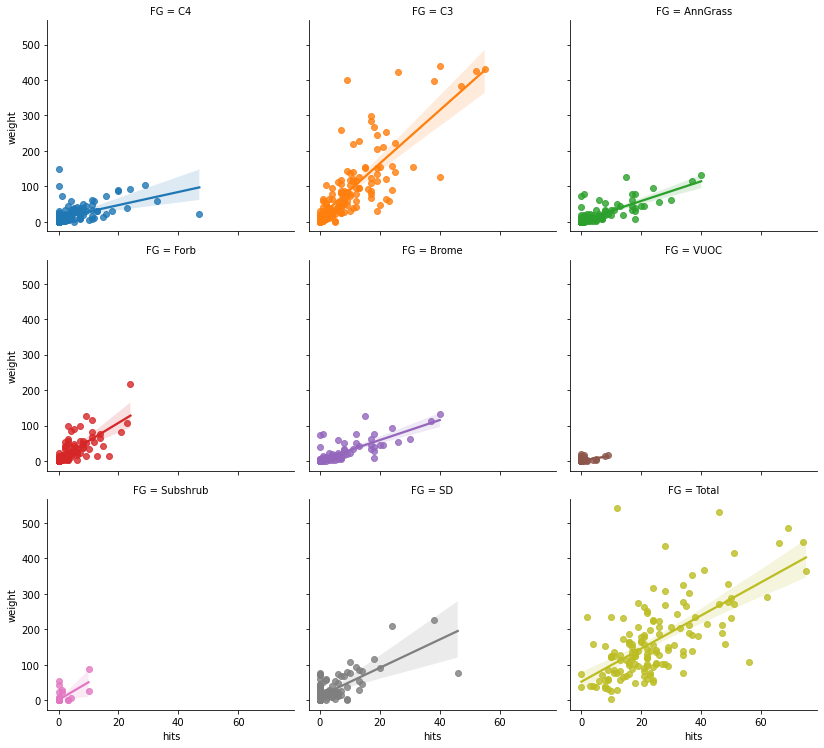

In [60]:
# plot linear fits for each functional group (FG)
sns.lmplot(x='hits',
           y='weight',
           col='FG',
           col_wrap=3,
           hue='FG',
           data=df_nex_pf_agg_long,
           scatter=True, height=3.5, aspect=1.1)

In [61]:
# explore outliers
df_nex_pf_agg[(df_nex_pf_agg.hits_C4 < 5) & (df_nex_pf_agg.weight_C4 > 50)]

,Site,Disturbance,Exclosure,Date,Total Hits,hits_C4,hits_C3,hits_AnnGrass,hits_Forb,hits_Brome,...,weight_Total,weight_C4,weight_C3,weight_Forb,weight_Brome,weight_VUOC,weight_AnnGrass,weight_Subshrub,weight_SD,Year
2,lake creek,control,livestock ex,2019-07-31,23,1,0,20,2,20,...,138.52,71.30,0.00,18.7,44.90,0.02,44.92,0.0,3.6,2019
26,lake creek,prairie dog,livestock ex,2019-07-31,37,4,3,26,3,26,...,211.60,59.70,37.70,56.3,53.60,1.90,55.50,0.0,2.4,2019
48,steckley,fire,livestock ex,2017-07-17,2,0,2,0,0,0,...,235.90,148.06,47.52,0.0,40.32,0.00,40.32,0.0,0.0,2017
51,steckley,fire,out,2017-07-17,8,0,8,0,0,0,...,153.82,99.64,53.60,0.0,0.58,0.00,0.58,0.0,0.0,2017


In [62]:
# drop meaningless columns
df_nex_pf_agg_long = df_nex_pf_agg_long.drop(columns=['index'])
# save datasets to disk
df_nex_pf_agg.to_csv(os.path.join(os.getcwd(), outDIR_pf_train, 'TB_nex_pf_train.csv'), index=False)
df_nex_pf_agg_long.to_csv(os.path.join(os.getcwd(), outDIR_pf_train, 'TB_nex_pf_train_long.csv'), index=False)

# VOR

In [63]:
# load vor data
df_nex_vor = nex_xlsx.parse(sheet_name='VOR 15-21', header=0)

In [64]:
# create an Excel file object for the plant list
tb_plant_list_xlsx = pd.ExcelFile(tb_plant_list_f)

# load TB master plant list
df_tb_plant_list = tb_plant_list_xlsx.parse(sheet_name='2020TB Fam-Sci-Functional', header=0)

2020TB Fam-Sci-Functional
2020TB Org.by FamilyFunctional
2020TB Org.by SciName
2020TB Org.byClippingFunctional


/home/spkearney/miniconda3/envs/hls_nrt_env/lib/python3.10/site-packages/openpyxl/worksheet/_read_only.py:79: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():


In [65]:
df_tb_plant_list['Functional group'].unique()

array(['P-Sub-Shrub', 'A-Forb', 'P-Forb', 'A/P-Forb', 'P-Shrub',
       'B/P-Forb', 'B-Forb', '?-Forb', 'A/B-Forb', 'A/B/P-Forb',
       'P-Cactus', 'P-C3 Grass', 'P-Fern', 'A&A/P-Forb', 'P-Lichen',
       'P-C4 Grass', 'A-Annual Brome', 'A-C4 Grass', 'A-C3 Grass',
       '?-C3 Grass', '?-Shrub', '?-Subshrub'], dtype=object)

In [66]:
def remap_fg(x):
    if 'Forb' in x:
        return 'Forb'
    elif 'Sub-Shrub' in x or 'Subshrub' in x:
        return 'Subshrub'
    elif 'P-Shrub' in x or '?-Shrub' in x:
        return 'Shrub'
    elif ('Grass' in x or 'Brome' in x) and 'A-' in x:
        return 'Annual grass'
    elif 'C3' in x:
        return 'C3 Perennial grass'
    elif 'C4' in x:
        return 'C4 Perennial grass'
    else:
        return x

In [67]:
df_tb_plant_list['Functional group'].apply(remap_fg).unique()

array(['Subshrub', 'Forb', 'Shrub', 'P-Cactus', 'C3 Perennial grass',
       'P-Fern', 'P-Lichen', 'C4 Perennial grass', 'Annual grass'],
      dtype=object)

In [68]:
tb_fg_dict = dict(zip(df_tb_plant_list['Symbol'], df_tb_plant_list['Functional group'].apply(remap_fg)))

### VOR dataset cleaning, aggregation and save to disk

In [69]:
# get manually adjusted low/high readings
# see T:\2-Projects\Thunder Basin\NestedExclosures\Data\Multi-Year Data\README-VORrulesforfixingdata.docx
df_nex_vor['Low_cm'] = df_nex_vor['low_cm_ADJUSTED']
df_nex_vor['High_cm'] = df_nex_vor['High_cm_ADJUSTED']
df_nex_vor = df_nex_vor.drop(columns=['low_cm_ADJUSTED', 'High_cm_ADJUSTED'])

In [70]:
# manually fix incorrect Transect IDs
#df_nex_vor.loc[(df_nex_vor['Exclosure'] == 'ungulate ex') & 
#               (df_nex_vor['Transect ID'] == 'lake creek-prairie dog-livestock ex'),
#              'Transect ID'] = 'lake creek-prairie dog-ungulate ex'
#df_nex_vor.loc[df_nex_vor['Transect ID'] == 'lake creek-control-livestock',
#              'Transect ID'] = 'lake creek-control-livestock ex'
#df_nex_vor.loc[df_nex_vor['Transect ID'] == 'westfork-control-livestock ex',
#              'Transect ID'] = 'west fork-control-livestock ex'
#df_nex_vor.loc[df_nex_vor['Transect ID'] == 'westfork-control-ungulate ex',
#              'Transect ID'] = 'west fork-control-ungulate ex'


In [71]:
# manually fix incorrect dates
#df_nex_vor[df_nex_vor['Date_Surveyed'].dt.year != df_nex_vor['Year']]['Date_Surveyed'].unique()
#df_nex_vor.loc[df_nex_vor['Date_Surveyed'] == np.datetime64('2021-07-15T00:00:00.000000000'), 
#              'Date_Surveyed'] = np.datetime64('2020-07-15T00:00:00.000000000')

In [72]:
df_nex_vor['Spp_code'].sort_values().unique()
#SSPea == PEAR
#Ugly AUX == FORB

array(['AGCR', 'ALDE', 'ALTE', 'ANT MOUND', 'APRU', 'ARCA', 'ARFR',
       'ARLU', 'ARPU', 'ARTR', 'ASGR', 'ATCA', 'BARE', 'BASC', 'BOGR',
       'BRAR', 'BRTE', 'CADU', 'CAFI', 'CAMI', 'CHAL', 'CHGL', 'CHPR',
       'COAR', 'COCA', 'CRMI ', 'DEPI', 'DUNG', 'ELEL', 'ERPU', 'GRSQ',
       'HECO', 'HECO*/HECO', 'HEHI', 'HOJU', 'HOPU', 'KOMA', 'KRLA',
       'LAOC', 'LASE', 'LEDE', 'LEPE', 'LICHEN', 'LIPU', 'LIRI', 'LITTER',
       'LOAR', 'LYJU', 'MATA', 'MONU', 'NAVI', 'NAVI ', 'OAK LEAF FORB',
       'OOMU', 'OPPO', 'PASM', 'PEAR', 'PEER', 'PHHO', 'PIOP', 'PLPA',
       'POAV', 'POSE', 'PRAIRIE DOG MOUND', 'SATR', 'SCPA', 'SD ARTR',
       'SD BRAR', 'SD HECO', 'SD MATA', 'SD NAVI', 'SD PASM', 'SD TRDU',
       'SILVER SCURF PEA', 'SOTR', 'SPCO', 'SPCR', 'TAOF', 'TRDU',
       'TRDU ', 'UGLY AUX', 'VEBR', 'VEPE', 'VIAM', 'VUOC', 'na', nan],
      dtype=object)

In [73]:
# define non-veg species
non_veg_spp = ['ANT MOUND', 'BARE', 'DUNG', 'LICHEN', 'PRAIRIE DOG MOUND', 'LITTER']

# fix erroneous species names
spp_remap_dict = {'HECI': 'HECO',
                  'HECO*/HECO': 'HECO',
                  'JECO': 'HECO',
                  'SILVER SCURF PEA': 'PEAR',
                  'CRMI ': 'CRMI',
                  'NAVI ': 'NAVI',
                  'TRDU ': 'TRDU',
                  'COAR': 'LOAR',
                  'APRU': 'ARPU',
                  'na': 'NA',
                  np.nan: 'NA'}
df_nex_vor['Spp_code'] = df_nex_vor['Spp_code'].apply(lambda x: spp_remap_dict[x] if x in spp_remap_dict.keys() else x)

In [75]:
# create list of species to drop from VOR data
vor_spp_drop_list = ['ATCA', 'atca', 'OPPO', 'oppo', 'ARTR', 'artr', 'SD ARTR', 'ARCA', 'arca', 'SD ATCA']

# drop VOR readings in species list
df_nex_vor = df_nex_vor[~df_nex_vor['Spp_code'].isin(vor_spp_drop_list)]

# prepare to convert 'High_cm' back to integer
df_nex_vor.loc[df_nex_vor['High_cm'] == '90+', 'High_cm'] = 90

# drop any rows with non-integer values of VOR readings
df_nex_vor = df_nex_vor[(df_nex_vor['Low_cm'].apply(lambda x: type(x) == int)) &
                        (df_nex_vor['High_cm'].apply(lambda x: type(x) == int))].copy()

# convert all VOR readings to integer
df_nex_vor['Low_cm'] = df_nex_vor['Low_cm'].astype('int')
df_nex_vor['High_cm'] = df_nex_vor['High_cm'].astype('int')

# set any non-veg low species that are not 0 to 0
df_nex_vor.loc[((df_nex_vor['Spp_code'].isin(non_veg_spp) & (df_nex_vor['Low_cm'] > 0))), 'Low_cm'] = 0

# drop VOR where low > high as suspected data entry errors
df_nex_vor = df_nex_vor[df_nex_vor['Low_cm'] <= df_nex_vor['High_cm']]

# drop any VOR readings of -1
df_nex_vor = df_nex_vor[(df_nex_vor['Low_cm'] >= 0) & (df_nex_vor['High_cm'] >= 0)]

# get total number of vor obs per site
vor_reading_cts = df_nex_vor.groupby(
    ['Site', 
     'Disturbance', 
     'Exclosure', 
     'Transect ID',
     'Date_Surveyed']).count()['Distance_along_transect_m']

# get percentage of readings remaining after dropping species
vor_reading_pct = (df_nex_vor.groupby(
    ['Site', 
     'Disturbance', 
     'Exclosure', 
     'Transect ID',
     'Date_Surveyed']).count()['Distance_along_transect_m'] / vor_reading_cts)#.reset_index()

In [76]:
for s in non_veg_spp:
    tb_fg_dict[s] = 'Non-veg'
    
tb_fg_dict['UGLY AUX'] = 'Forb'
tb_fg_dict['OAK LEAF FORB'] = 'Forb'
tb_fg_dict['LIPU'] = 'Forb'
tb_fg_dict['NA'] = 'Unkown'

In [77]:
# create simplified species code for getting dominant species
df_nex_vor['Spp_code_simp'] = df_nex_vor['Spp_code'].apply(lambda x: re.sub('SD ', '', x))

In [78]:
df_nex_vor['FG'] = df_nex_vor['Spp_code_simp'].apply(lambda x: tb_fg_dict[x])

In [79]:
# get VOR counts by species
vor_domin_spp = df_nex_vor.groupby(
    ['Site', 
     'Disturbance', 
     'Exclosure', 
     'Transect ID',
     'Date_Surveyed'])['Spp_code_simp'].value_counts().to_frame('count')
# get dominant species by index
vor_domin_spp = vor_domin_spp.loc[vor_domin_spp.groupby(
    level=['Site', 
           'Disturbance', 
           'Exclosure', 
           'Transect ID',
           'Date_Surveyed'])['count'].idxmax()].reset_index(level=-1)
# calculate the percent of hits associated with species by index
vor_domin_spp['pct'] = vor_domin_spp['count'] / vor_reading_cts

# get VOR counts by functional group
vor_domin_fg = df_nex_vor.groupby(
    ['Site', 
     'Disturbance', 
     'Exclosure', 
     'Transect ID',
     'Date_Surveyed'])['FG'].value_counts().to_frame('count')
# get dominant species by index
vor_domin_fg = vor_domin_fg.loc[vor_domin_fg.groupby(
    level=['Site', 
           'Disturbance', 
           'Exclosure', 
           'Transect ID',
           'Date_Surveyed'])['count'].idxmax()].reset_index(level=-1)
# calculate the percent of hits associated with species by index
vor_domin_fg['pct'] = vor_domin_fg['count'] / vor_reading_cts

In [80]:
# get mean of each experimental unit
df_nex_vor_out = df_nex_vor.groupby(
    ['Site', 'Disturbance', 'Exclosure', 'Transect ID', 'Date_Surveyed']).mean()

# get dominant species
df_nex_vor_out['domin_spp'] = vor_domin_spp['Spp_code_simp']
df_nex_vor_out['domin_spp_pct'] = vor_domin_spp['pct']
df_nex_vor_out.loc[df_nex_vor_out['domin_spp_pct'] < 0.40, 'domin_spp'] = 'Mixed'

# get dominant species
df_nex_vor_out['domin_fg'] = vor_domin_fg['FG']
df_nex_vor_out['domin_fg_pct'] = vor_domin_fg['pct']
df_nex_vor_out.loc[df_nex_vor_out['domin_fg_pct'] < 0.40, 'domin_spp'] = 'Mixed'

# get percent of valid herbaceous readings
df_nex_vor_out['vor_reading_pct'] = vor_reading_pct

# reset index
df_nex_vor_out = df_nex_vor_out.reset_index()

# drop any sites where < 50% of readings are valid
df_nex_vor_out = df_nex_vor_out[df_nex_vor_out['vor_reading_pct'] > 0.5]

# reset the year column
df_nex_vor_out['Year'] = df_nex_vor_out['Date_Surveyed'].dt.year

# drop meaningless columns
df_nex_vor_out = df_nex_vor_out.drop(columns=['Distance_along_transect_m'])

# rename date columns
df_nex_vor_out = df_nex_vor_out.rename(columns={'Date_Surveyed': 'Date'})

In [81]:
# get GPS locs from transect shapefile (centroids)
df_nex_vor_out = pd.merge(df_nex_vor_out,
                          gdf_nex[['Transect ID', 'Mean.GPS_E.Biomass', 'Mean.GPS_N.Biomass']],
                          on= 'Transect ID',
                          suffixes=['_vor', '_shp'],
                          how='left')

In [82]:
df_nex_vor_out.to_csv(os.path.join(os.getcwd(), outDIR_vor, 'TB_nex_vor.csv'), index=False)

### *Combine with biomass dataset*

##### *Additional biomass cleaning*

In [83]:
remove_indv_na = True
if remove_indv_na:
    df_nex_bm = df_nex_bm[~(
        df_nex_bm.loc[:, df_nex_bm.columns.str.contains('weight \(g\)')] < 0).any(axis=1)]

In [84]:
# join Biomass and VOR datasets using Biomass dates with a definted maximum threshold of date difference
df_nex_vor_bm = pd.merge_asof(df_nex_vor.sort_values('Date_Surveyed'), 
                           df_nex_bm.groupby(['Site',
                                              'Disturbance',
                                              'Exclosure',
                                              'Date_cln']).mean().reset_index().sort_values('Date_cln')[
                               ['Site',
                                'Disturbance',
                                'Exclosure',
                                'Area (m^2)',
                                'Total Weight (g)',
                                'Total Weight (g/m^2)',
                                'Date_cln']],
                              left_on='Date_Surveyed',
                              right_on='Date_cln',
                              by=['Site', 'Disturbance', 'Exclosure'],
                              direction='nearest',
                              tolerance=datetime.timedelta(days=21),
                              suffixes=['_x', ''],)
# add and rename biomass observers to be clear
df_nex_vor_bm['bm_domin_obs'] = df_nex_bm_out['domin_obs']

In [85]:
# drop any records missing Biomass data
df_nex_vor_bm = df_nex_vor_bm[df_nex_vor_bm['Total Weight (g/m^2)'].notnull()]

In [86]:
# get updated total number of vor obs per site
vor_reading_cts = df_nex_vor_bm.groupby(
    ['Site', 
     'Disturbance', 
     'Exclosure', 
     'Date_Surveyed', 
     'Date_cln']).count()['Distance_along_transect_m']

In [169]:
# add GPS locations of transect centers to VOR data
df_nex_vor_bm = pd.merge(df_nex_vor_bm,
         gdf_nex[['Transect ID', 'Mean.GPS_E.Biomass', 'Mean.GPS_N.Biomass']],
         on= 'Transect ID',
         suffixes=['_clip', '_shp'],
         how='left')

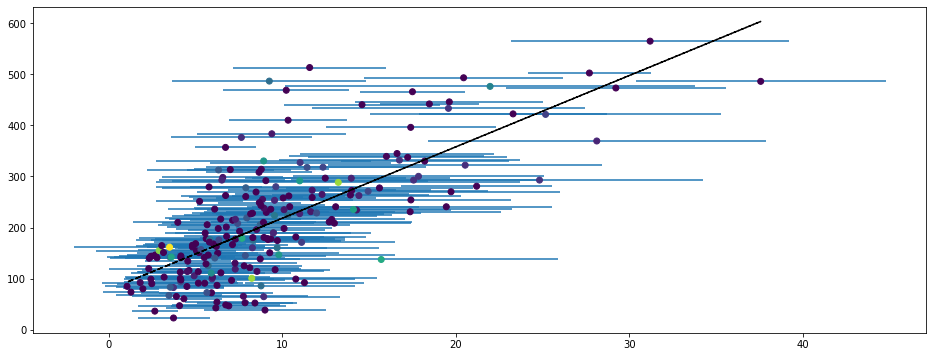

In [161]:
vor_mask = df_nex_vor_bm.groupby(
    ['Site', 'Disturbance', 'Exclosure', 'Date_Surveyed', 'Date_cln']).apply(lambda x: (x['Low_cm'] > (x['Low_cm'].mean() + x['Low_cm'].std()*4))).values

fig, ax = plt.subplots(figsize=(16, 6))
# get mean of each experimental unit
x_mean = df_nex_vor_bm[~vor_mask].groupby(
    ['Site', 'Disturbance', 'Exclosure', 'Date_Surveyed', 'Date_cln']).mean()['Low_cm']
y_mean = df_nex_vor_bm[~vor_mask].groupby(
    ['Site', 'Disturbance', 'Exclosure', 'Date_Surveyed', 'Date_cln']).mean()['Total Weight (g/m^2)']

x_std = df_nex_vor_bm[~vor_mask].groupby(
    ['Site', 'Disturbance', 'Exclosure', 'Date_Surveyed', 'Date_cln']).std()['Low_cm']

coef_std = np.polyfit(x_mean, x_std, 1)
poly1d_fn_std = np.poly1d(coef_std)
x_std_diff = x_std - poly1d_fn_std(x_mean)
x_cv = (x_std/x_mean).values
x_cv_norm = (x_std_diff/x_mean).values

coef = np.polyfit(x_mean, y_mean, 1)
poly1d_fn = np.poly1d(coef) 
# poly1d_fn is now a function which takes in x and returns an estimate for y
ax.errorbar(x_mean, y_mean, xerr=x_std, fmt='none', zorder=1)
ax.plot(x_mean, poly1d_fn(x_mean), '--k', zorder=10) #'--k'=black dashed line, 'yo' = yellow circle marker
# plot linear fit of low VOR reading and Biomass
ax.scatter(x_mean, y_mean, c=x_cv_norm, cmap='viridis', vmin=0, vmax=0.5, zorder=5)


In [165]:
vor_mask.sum()

9

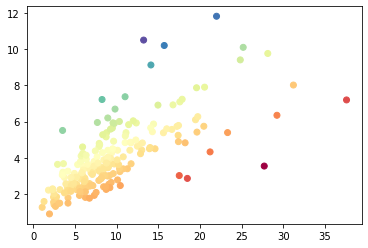

In [126]:
coef_std = np.polyfit(x_mean, x_std, 1)
poly1d_fn_std = np.poly1d(coef_std)
x_std_diff = x_std - poly1d_fn_std(x_mean)
plt.scatter(x_mean, x_std, c=x_std_diff, cmap='Spectral')

In [131]:
x_cv_norm.max()

0.8323477266715172

### *Clean VOR dataset*

### *Create dataset of mean values by experimental unit*

In [170]:
# get VOR counts by species
vor_domin_spp_agg = df_nex_vor_bm.groupby(
    ['Site', 
     'Disturbance', 
     'Exclosure', 
     'Date_Surveyed', 
     'Date_cln'])['Spp_code_simp'].value_counts().to_frame('count')
# get dominant species by index
vor_domin_spp_agg = vor_domin_spp_agg.loc[vor_domin_spp_agg.groupby(
    level=['Site', 
     'Disturbance', 
     'Exclosure', 
     'Date_Surveyed', 
     'Date_cln'])['count'].idxmax()].reset_index(level=-1)
# calculate the percent of hits associated with species by index
vor_domin_spp_agg['pct'] = vor_domin_spp_agg['count'] / vor_reading_cts

# get VOR counts by functional group
vor_domin_fg_agg = df_nex_vor_bm.groupby(
    ['Site', 
     'Disturbance', 
     'Exclosure', 
     'Date_Surveyed', 
     'Date_cln'])['FG'].value_counts().to_frame('count')
# get dominant species by index
vor_domin_fg_agg = vor_domin_fg_agg.loc[vor_domin_fg_agg.groupby(
    level=['Site', 
     'Disturbance', 
     'Exclosure', 
     'Date_Surveyed', 
     'Date_cln'])['count'].idxmax()].reset_index(level=-1)
# calculate the percent of hits associated with functional group by index
vor_domin_fg_agg['pct'] = vor_domin_fg_agg['count'] / vor_reading_cts


# get VOR counts by observer
vor_domin_obs_agg = df_nex_vor_bm.groupby(
    ['Site', 
     'Disturbance', 
     'Exclosure', 
     'Date_Surveyed', 
     'Date_cln'])['Observer'].value_counts().to_frame('obs_count')
# get dominant observer by index
vor_domin_obs_agg = vor_domin_obs_agg.loc[vor_domin_obs_agg.groupby(
    level=['Site', 
     'Disturbance', 
     'Exclosure', 
     'Date_Surveyed', 
     'Date_cln'])['obs_count'].idxmax()].reset_index(level=-1)


# get percentage of readings remaining after dropping species
vor_reading_pct = (df_nex_vor_bm.groupby(
    ['Site', 
     'Disturbance', 
     'Exclosure', 
     'Date_Surveyed', 
     'Date_cln']).count()['Distance_along_transect_m'] / vor_reading_cts)

# get mean of each experimental unit
df_nex_vor_agg = df_nex_vor_bm.groupby(
    ['Site', 'Disturbance', 'Exclosure', 'Date_Surveyed', 'Date_cln']).mean()

# get dominant species
df_nex_vor_agg['domin_spp'] = vor_domin_spp_agg['Spp_code_simp']
df_nex_vor_agg['domin_spp_pct'] = vor_domin_spp_agg['pct']
df_nex_vor_agg.loc[df_nex_vor_agg['domin_spp_pct'] < 0.40, 'domin_spp'] = 'Mixed'

# get dominant functional group
df_nex_vor_agg['domin_fg'] = vor_domin_fg_agg['FG']
df_nex_vor_agg['domin_fg_pct'] = vor_domin_fg_agg['pct']
df_nex_vor_agg.loc[df_nex_vor_agg['domin_fg_pct'] < 0.40, 'domin_fg'] = 'Mixed'

# get dominant observer
df_nex_vor_agg['domin_obs'] = vor_domin_obs_agg['Observer']

# get percent of valid herbaceous readings
df_nex_vor_agg['vor_reading_pct'] = vor_reading_pct

# reset index
df_nex_vor_agg = df_nex_vor_agg.reset_index()

# drop any sites where < 50% of readings are valid
df_nex_vor_agg = df_nex_vor_agg[df_nex_vor_agg['vor_reading_pct'] > 0.5]

# reset the year column
df_nex_vor_agg['Year'] = df_nex_vor_agg['Date_Surveyed'].dt.year

# drop meaningless columns
df_nex_vor_agg = df_nex_vor_agg.drop(columns=['Distance_along_transect_m'])

# rename date columns
df_nex_vor_agg = df_nex_vor_agg.rename(columns={'Date_Surveyed': 'Date'})

In [171]:
df_nex_vor_agg[df_nex_vor_agg['Year'] == 2021]

,Site,Disturbance,Exclosure,Date,Date_cln,Year,High_cm,Low_cm,Area (m^2),Total Weight (g),Total Weight (g/m^2),Mean.GPS_E.Biomass,Mean.GPS_N.Biomass,domin_spp,domin_spp_pct,domin_fg,domin_fg_pct,domin_obs,vor_reading_pct
4,lake creek,control,livestock ex,2021-07-08,2021-07-08,2021,23.942857,6.914286,0.1,4.673333,46.733333,490771.571731,4.797154e+06,BRTE,0.542857,Annual grass,0.542857,"dp, shs",1.0
10,lake creek,control,out,2021-07-08,2021-07-08,2021,20.321429,3.892857,0.1,6.516667,65.166667,490853.172237,4.797254e+06,Mixed,0.357143,C3 Perennial grass,0.500000,"shs, mh",1.0
16,lake creek,control,ungulate ex,2021-07-08,2021-07-08,2021,31.611111,11.111111,0.1,17.096667,170.966667,490771.457924,4.797235e+06,BRTE,0.611111,Annual grass,0.611111,"dp, shs",1.0
35,lake creek,prairie dog,livestock ex,2021-07-01,2021-07-01,2021,20.771429,6.457143,0.1,11.143333,111.433333,489278.555490,4.798367e+06,BRTE,0.885714,Annual grass,0.885714,"dp, shs",1.0
40,lake creek,prairie dog,out,2021-07-06,2021-07-06,2021,18.650000,4.075000,0.1,4.710000,47.100000,489198.363213,4.798347e+06,Mixed,0.350000,Mixed,0.375000,as,1.0
45,lake creek,prairie dog,ungulate ex,2021-07-01,2021-07-01,2021,25.675000,8.450000,0.1,19.590000,195.900000,489197.686374,4.798367e+06,BRTE,0.475000,Annual grass,0.500000,shs,1.0
51,steckley,control,livestock ex,2021-06-28,2021-06-30,2021,32.178571,8.928571,0.1,6.470000,64.700000,476447.121292,4.808577e+06,Mixed,0.357143,C3 Perennial grass,0.500000,"shs, dp, as, lp",1.0
57,steckley,control,out,2021-06-30,2021-06-30,2021,32.625000,6.916667,0.1,4.860000,48.600000,476447.138217,4.808597e+06,Mixed,0.291667,C3 Perennial grass,0.583333,"as, shs",1.0
64,steckley,control,ungulate ex,2021-06-30,2021-06-30,2021,15.000000,3.727273,0.1,2.306667,23.066667,476366.233634,4.808497e+06,Mixed,0.272727,C3 Perennial grass,0.454545,dp,1.0
83,steckley,prairie dog,livestock ex,2021-07-01,2021-07-01,2021,27.000000,11.275000,0.1,9.216667,92.166667,476490.905733,4.809693e+06,PASM,1.000000,C3 Perennial grass,1.000000,"shs, dp",1.0


### *Check data and save to disk*

In [172]:
df_nex_vor_agg.groupby('Year').count()

,Site,Disturbance,Exclosure,Date,Date_cln,High_cm,Low_cm,Area (m^2),Total Weight (g),Total Weight (g/m^2),Mean.GPS_E.Biomass,Mean.GPS_N.Biomass,domin_spp,domin_spp_pct,domin_fg,domin_fg_pct,domin_obs,vor_reading_pct
Year,,,,,,,,,,,,,,,,,,
2015,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20
2017,29,29,29,29,29,29,29,29,29,29,29,29,29,29,29,29,29,29
2018,36,36,36,36,36,36,36,36,36,36,36,36,36,36,36,36,36,36
2019,36,36,36,36,36,36,36,36,36,36,36,36,36,36,36,36,36,36
2020,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33
2021,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30
2022,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30


In [173]:
df_nex_vor_agg[(df_nex_vor_agg['Year'] == 2021) &
               (df_nex_vor_agg['Low_cm'] > 6) &
               (df_nex_vor_agg['Total Weight (g/m^2)'] < 75)]

,Site,Disturbance,Exclosure,Date,Date_cln,Year,High_cm,Low_cm,Area (m^2),Total Weight (g),Total Weight (g/m^2),Mean.GPS_E.Biomass,Mean.GPS_N.Biomass,domin_spp,domin_spp_pct,domin_fg,domin_fg_pct,domin_obs,vor_reading_pct
4,lake creek,control,livestock ex,2021-07-08,2021-07-08,2021,23.942857,6.914286,0.1,4.673333,46.733333,490771.571731,4.797154e+06,BRTE,0.542857,Annual grass,0.542857,"dp, shs",1.0
51,steckley,control,livestock ex,2021-06-28,2021-06-30,2021,32.178571,8.928571,0.1,6.470000,64.700000,476447.121292,4.808577e+06,Mixed,0.357143,C3 Perennial grass,0.500000,"shs, dp, as, lp",1.0
57,steckley,control,out,2021-06-30,2021-06-30,2021,32.625000,6.916667,0.1,4.860000,48.600000,476447.138217,4.808597e+06,Mixed,0.291667,C3 Perennial grass,0.583333,"as, shs",1.0
102,west fork,control,livestock ex,2021-07-13,2021-07-13,2021,21.894737,8.421053,0.1,5.230000,52.300000,490658.466198,4.822442e+06,Mixed,0.342105,Annual grass,0.605263,shs,1.0
109,west fork,control,out,2021-07-13,2021-07-13,2021,19.307692,6.230769,0.1,5.413333,54.133333,490759.414642,4.822361e+06,BRAR,0.538462,Annual grass,0.538462,shs,1.0
161,wildcat,control,livestock ex,2021-07-07,2021-07-12,2021,17.166667,6.166667,0.1,4.270000,42.700000,517821.283545,4.835710e+06,HECO,0.416667,C3 Perennial grass,0.888889,shs,1.0
173,wildcat,control,ungulate ex,2021-07-07,2021-07-12,2021,19.729730,7.756757,0.1,6.550000,65.500000,517821.283545,4.835790e+06,PASM,0.702703,C3 Perennial grass,0.756757,as,1.0
180,wildcat,fire,livestock ex,2021-07-07,2021-07-07,2021,20.725000,7.850000,0.1,5.280000,52.800000,518672.235692,4.836930e+06,PASM,0.500000,C3 Perennial grass,0.650000,shs,1.0
194,wildcat,fire,ungulate ex,2021-07-07,2021-07-07,2021,23.153846,9.000000,0.1,3.850000,38.500000,518591.315427,4.836930e+06,BRTE,0.538462,Annual grass,0.564103,dp,1.0


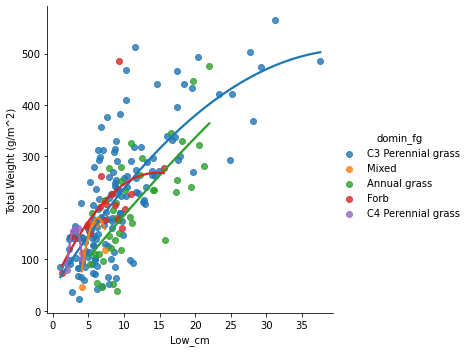

In [174]:
# plot linear fit of low VOR reading and Biomass
sns.lmplot(x='Low_cm', 
           y='Total Weight (g/m^2)',
           hue='domin_fg',
           ci=None,
           order=2,
          data=df_nex_vor_agg)

In [175]:
# save final data to disk
df_nex_vor_agg.to_csv(os.path.join(os.getcwd(), outDIR_vor_train, 'TB_nex_vor_train.csv'), index=False)

# Questions
### Biomass 
* What is the Rep? Only one rep for Pin frame and 3 reps for BM..
  * should I average all reps or just take Rep 1?
 
### Pin frame 
* What should be the final functional groups?
  * currently considering:
     * Annuals (BROME + VUOC)
     * Forbs (PerFORB + AnnFORB)
     * C3
     * C4
     * Subshrub
* How to combine functional group in model?
  * currently planning separate models for each FG
* What is TotalHerbHits? Do I need to calculate herb weight?
  * currently I am calculaing an herb weight from biomass clipping as: Total - SD
* Should I be dropping basal hits?
* Ok to drop Shrub/Oppo (no corresponding Biomass clipping)
  * or should we sites with high shrub/oppo?
* PASM vs. COMP? (!this is just for FQ)

### VOR 
* Which species to drop from VOR?
  * for CPER we dropped: ['OPPO', 'ATCA', 'GUSA', 'EREF', 'ARFR', 'ERNA', 'KRLA', 'YUGL']
  * currently I am just dropping OPPO and ATCA
* Should I clean up outliers?
  * for CPER we used cut-off of 50 cm height (for high) and 2.5 sd's
  * currently I am removing high > 75 cm and low > high
* Max date difference between clipping and VOR?
  * currently I am using 15 days
  
### PVSAGE
* Anything different to be aware of?
* Only use pre-treatment data for satellite extraction?
    * Is the first year (2016?) baseline data pre-treatment? 

In [60]:
#remove negative values
# red cells will be NAN (check latest saved data)
# Note that there is biomass data with no corresponding PF data (and not by FG)
#drop all biomass data not used for pin frame calibration before PF join (then you won't be worrying about reps).
#Add BOGR/BUDA back into C4 when present (starting in 2020)
#drop all PASM data from Biomass
#starting in 2019 need to add together annual and perennial forbs, but prior is just forbs

# VOR
#leave all high numbers. Change 90+ to 90
# could check datasheets when low > high (ask Katie)
#change date tolerance to 10 days max (look at VOR, should through out all of 2015-17, but very few in 2018+),
#maybe reduce tolerance if needbe
# YEAR IS WRONG FOR VOR DATA
# CHANGE JUNE 2016 AND JUNE AND JULY 2017 DATES FOR VOR BIOMASS TO BE LATE JUNE AND EARLY JULY??